In [1]:
from utils import load_embedding, parse_tup, cos_sim, cos_dist
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()
TIME_FRAME = "monthly"

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
embedding = load_embedding("/h/224/cameron/Political-Subreddit-Embedding/trained_embeddings/vecs_0.0028_15.0.txt",split=False)
embedding

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
subreddit,,,,,,,,,,,,,,,,,,,,,
SquaredCircle,0.134779,0.043821,-0.011876,-0.066840,0.020694,-0.055040,0.017334,0.004694,-0.082625,0.124690,...,-0.061495,-0.183028,-0.099551,0.031485,-0.040188,0.143292,0.040536,-0.008464,0.041863,-0.172806
AskReddit,0.135559,0.008985,-0.037187,0.000455,0.022365,-0.006085,-0.017524,0.040978,-0.054059,0.069235,...,-0.039066,-0.043172,-0.106157,0.105634,-0.045787,0.063289,0.057239,-0.198356,0.061649,-0.023330
politics,-0.042422,0.024062,-0.165820,0.046046,-0.080393,0.024717,0.044797,0.094564,-0.090970,0.013700,...,0.034073,-0.087685,-0.129094,0.110916,0.047369,0.014214,0.025798,-0.121198,0.155587,-0.057969
memes,0.002449,-0.014680,-0.031889,-0.051864,0.044783,-0.055175,0.063965,0.009760,-0.135631,0.106458,...,0.024190,-0.042757,-0.033878,0.041545,-0.001212,0.076116,0.036539,-0.102034,0.054330,-0.073219
teenagers,0.026058,0.069684,0.024581,0.009624,-0.029134,0.076384,0.078542,0.052331,-0.106552,0.096511,...,0.013686,-0.014345,-0.004146,0.055941,-0.009106,0.085962,0.030374,-0.028468,0.069988,-0.039540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NRV,0.122154,0.130032,-0.243602,-0.032611,-0.038153,-0.014279,-0.065262,-0.001528,-0.099809,-0.018441,...,-0.054521,-0.062958,-0.112747,0.098669,-0.049754,-0.015509,0.117170,-0.216936,0.008118,-0.123790
UTT,0.135902,0.057751,-0.200740,-0.035059,-0.005987,-0.000219,-0.083139,0.033362,-0.119045,0.125617,...,-0.019219,-0.092823,-0.096780,0.095344,-0.114785,0.023995,0.075017,-0.151421,0.048709,-0.065192
MMU,0.119556,0.049138,-0.134668,0.009505,0.023105,-0.025217,-0.026836,-0.026815,-0.198236,0.021817,...,-0.075906,-0.067976,-0.035603,-0.009426,-0.084691,0.068536,-0.040373,-0.134642,0.068508,-0.132696


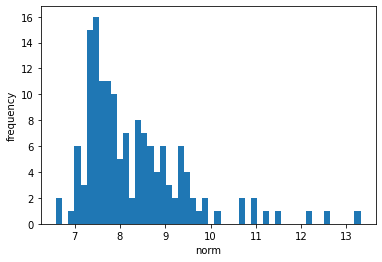

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(np.linalg.norm(embedding, axis=0), bins=50)
plt.ylabel("frequency")
plt.xlabel("norm")
plt.show()

In [4]:
religious_dim = [("Christianity","exchristian"),("TraditionalCatholics","excatholic"),("lds","exmormon"),("islam","exmuslim")]
ideological_dim =[("Conservative","progressive"),("Republican","democrats"),("conservatives","SocialDemocracy"),("TheNewRight","WeAreNotAsking")]
bc_dim = [("antifeminists","Feminism"),("prolife","prochoice"),("prolife","birthcontrol")]
gun_control_dim = ("progun","GunsAreCool")
young_old_dim = [("teenagers","datingoverforty"),("teenagersnew","RedditForGrownups")]
dims = {"religious-secular":religious_dim,"right-left": ideological_dim, "prolife-prochoice": bc_dim, "progun-guncontrol":gun_control_dim,"young-old":young_old_dim}

In [18]:
def calculate_dim(dimensions,e,return_stats=False):
    """
        Takes in a list of tuples and calcualtes the dimension from ap -> a. IE if we have the subreddits AskMen (a) and
        AskWomen (ap). The "masculine" vector transformation is a - ap.
        Returns the average transformation and a tuple containing the mean and std deviation similarity between the individual 
        transformations.
    """
    dimensions = dimensions if type(dimensions) is list else [dimensions]
    calc_trans = lambda vec_a,vec_ap : vec_a - vec_ap 
    transformations = np.array([calc_trans(e.loc[a],e.loc[ap]) for (a,ap) in dimensions])
    transformation = transformations.flatten() if transformations.shape[0] == 1 else np.mean(transformations,axis=0)
    if return_stats:
        sims = [cos_sim(t1,t2)  for t1 in list(transformations) for t2 in list(transformations) if not np.all(t1==t2)]
        return transformation, (np.mean(sims),np.std(sims))
    return transformation

project_dim = lambda dim,sub,e : cos_sim(dim,e.loc[sub])

In [19]:
proj_df = pd.DataFrame(dict(subreddit=embedding.index)).set_index("subreddit")



for name, dim in dims.items():
    dim, stats = calculate_dim(dim,embedding,True)
    projections = embedding.index.map(lambda x: project_dim(dim,x,embedding))
    proj_df[f"{name}_projection"] = projections
    
proj_df.head()
    
# fig.add_trace(go.Box(y=data, quartilemethod="inclusive", name="Inclusive Quartile Mode"))
# fig.add_trace(go.Box(y=data, quartilemethod="exclusive", name="Exclusive Quartile Mode"))


#     print("--------------------\n{} dimension\n\t* Average cosine similarity of transformations: {:.2f} (Std Deviation: {:.4f})".format(name,*stats))
#     print("{} {} scale: {:.2f}".format("prolife",name,project_dim(dim,"prolife",embedding)))
#     print("{} {} scale: {:.2f}".format("progun",name,project_dim(dim,"progun",embedding)))
#     print("{} {} scale: {:.2f}".format("Conservative",name,project_dim(dim,"Conservative",embedding)))
#     print("{} {} scale: {:.2f}".format("The_Donald",name,project_dim(dim,"The_Donald",embedding)))
#     print("{} {} scale: {:.2f}".format("JoeBiden",name,project_dim(dim,"JoeBiden",embedding)))
#     print("{} {} scale: {:.2f}".format("Pete_Buttigieg",name,project_dim(dim,"Pete_Buttigieg",embedding)))
#     print("{} {} scale: {:.2f}".format("SandersForPresident",name,project_dim(dim,"SandersForPresident",embedding)))
#     print("{} {} scale: {:.2f}".format("GunsAreCool",name,project_dim(dim,"GunsAreCool",embedding)))
#     print("{} {} scale: {:.2f}".format("prochoice",name,project_dim(dim,"prochoice",embedding)))

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,religious-secular_projection,right-left_projection,prolife-prochoice_projection,progun-guncontrol_projection,young-old_projection
subreddit,,,,,
SquaredCircle,0.160854,-0.008098,0.100125,-0.069259,0.017394
AskReddit,0.016020,0.048061,-0.129520,-0.011305,0.099381
politics,-0.067153,0.003846,0.027203,-0.138827,-0.211231
memes,0.085589,0.102064,0.038519,0.148239,0.477564
teenagers,0.092293,0.144580,0.078028,0.181508,0.690425


In [ ]:
fig = go.Figure()
[fig.add_trace(go.Box(y=proj_df[n],quartilemethod="linear", name=f"{n}_projection")) for n in proj_df.columns]
fig.update_traces(boxpoints='all', jitter=0)
fig.show()